# Unevenly Spaced Item Grouping
In the design-to-code process one of the first steps is to “fix” the design to make sure certain best-
practices are followed to allow the most accurate and correct code generation.

One of those necessary design fixes is to group elements together so that they can be correctly
converted into responsive flex layouts.
This is necessary because modern webpages are expected to be responsive and look good on
different sized screens.

In [1]:
import json
import os
from PIL import Image

In [2]:
ROOT_FOLDER = "Locofy_MLE_Challenge_Groupings"

DATA_FOLDER = os.path.join(ROOT_FOLDER, "Data")
IMAGE_FOLDER = os.path.join(ROOT_FOLDER, "Images")

Let's start with the problem, what we need to do is grouping single items into groups of items, below is an visualized image of input data:

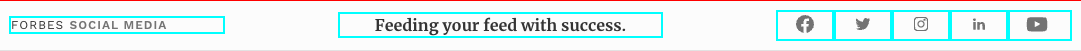

In [3]:
Image.open(os.path.join(IMAGE_FOLDER, "15_ungrouped.png"))

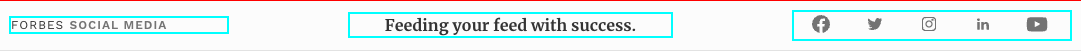

In [4]:
# and the output:
Image.open(os.path.join(IMAGE_FOLDER, "15_grouped.png"))

We can see that five rightmost items are grouped into one single group, that's what we need to achieve.

initial thoughts:
- these grouped items sit next to each other -> location information should be important  
- those grouped items are the same types: all of them are icon -> element type information should also be useful

The associated data going with this (input, output) pair is:
```
input: [[a,4], [0,2], [b,5], [0,3], [c,5], [d,4]]
output: [[a,b], c, d]
```

where:
- 1st elements in the input item: a, b, c, d, etc. are names of elements; and 0 represent `space` element
- 2nd elements in the input item: 4, 2, 5, 3, etc. are corresponding size (height or width of the element)


We can see that we only have 1D information of the element, let's visualize it in 1D dimension:

[['a', 60], ['0', 15], ['b', 70], ['0', 15], ['cdefg', 50]]


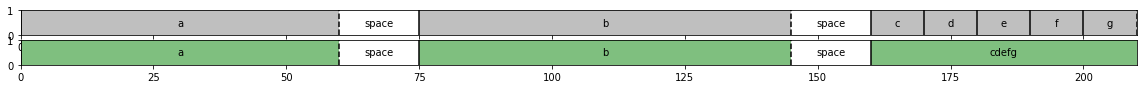

In [5]:
inputs =  [["a", 60], ["0", 15], ["b", 70], ["0", 15], ["c", 10], ["d", 10], ["e", 10], ["f", 10], ["g", 10]]
outputs = ["a", "b", ["c", "d", "e", "f", "g"]]

# visualize the input data in line chart
import matplotlib.pyplot as plt
import numpy as np

def visualize(inputs, outputs):
    # create a figure
    fig = plt.figure(figsize=(20, 1))
    ax = fig.add_subplot(211)

    # plot the input data
    accumulated_size = 0
    for i, (name, size) in enumerate(inputs):
        if name == "0":
            ax.axvline(x=accumulated_size, color='k', linestyle='--')
            ax.text(accumulated_size + size / 2, 0.5, "space", ha='center', va='center')
        else:
            ax.axvline(x=accumulated_size, color='k', linestyle='-')
            ax.axvspan(accumulated_size, accumulated_size + size, facecolor='gray', alpha=0.5)
            ax.text(accumulated_size + size / 2, 0.5, name, ha='center', va='center')
        accumulated_size += size
        
    ax.axvline(x=accumulated_size, color='k', linestyle='--')
    ax.set_xlim(0, accumulated_size)

    # visualize output
    cloned_inputs = inputs.copy()
    output_pairs = []
    for i, output in enumerate(outputs):
        if isinstance(output, str):
            item = cloned_inputs.pop(0)
            while item[0] == "0":
                output_pairs.append([item[0], item[1]])
                item = cloned_inputs.pop(0)
            output_pairs.append([output, item[1]])
        else:
            item = cloned_inputs.pop(0)
            while item[0] == "0":
                output_pairs.append([item[0], item[1]])
                item = cloned_inputs.pop(0)

            # now we have first item that is not "0" - space
            items = [item]
            if item[0] != "0":
                output.pop(0)
            while output and cloned_inputs:
                item = cloned_inputs.pop(0)
                items.append(item)
                if item[0] != "0":
                    output.pop(0)

            output_pairs.append(["".join([item[0] for item in items]), sum([item[1] for item in items])])
    
    while len(cloned_inputs) > 0:
        item = cloned_inputs.pop(0)
        output_pairs.append([item[0], item[1]])
        
    print(output_pairs)

    # fig = plt.figure(figsize=(20, 1))
    ax2 = fig.add_subplot(212)

    # plot the input data
    accumulated_size = 0
    for i, (name, size) in enumerate(output_pairs):
        if name == "0":
            ax2.axvline(x=accumulated_size, color='k', linestyle='--')
            ax2.text(accumulated_size + size / 2, 0.5, "space", ha='center', va='center')
        else:
            ax2.axvline(x=accumulated_size, color='k', linestyle='-')
            ax2.axvspan(accumulated_size, accumulated_size + size, facecolor='green', alpha=0.5)
            ax2.text(accumulated_size + size / 2, 0.5, name, ha='center', va='center')
        accumulated_size += size

    ax2.set_xlim(0, accumulated_size)
    
    return fig

fig = visualize(inputs, outputs)

Let's see what we have in our data

{'id': 0, 'input': [['0', 80], ['a', 32], ['0', 8], ['b', 103], ['0', 379], ['c', 300], ['0', 379], ['d', 16], ['e', 88], ['0', 40]], 'output': [['a', 'b'], 'c', ['d', 'e']], 'direction': 'horizontal'}
[['0', 80], ['a0b', 143], ['0', 379], ['c', 300], ['0', 379], ['de', 104], ['0', 40]]
----------------------------------------------------------------------------------------------------
{'id': 13, 'input': [['a', 122], ['b', 196], ['0', 673], ['c', 164], ['0', 24], ['d', 86]], 'output': [['a', 'b'], ['c', 'd']], 'direction': 'horizontal'}
[['ab', 318], ['0', 673], ['c0d', 274]]
----------------------------------------------------------------------------------------------------
{'id': 14, 'input': [['a', 102], ['0', 16], ['b', 46], ['0', 24], ['c', 18], ['0', 16], ['d', 18], ['0', 16], ['e', 18]], 'output': [['a', 'b'], ['c', 'd', 'e']], 'direction': 'horizontal'}
[['a0b', 164], ['0', 24], ['c0d0e', 86]]
------------------------------------------------------------------------------------

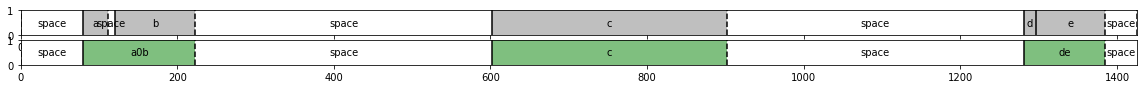

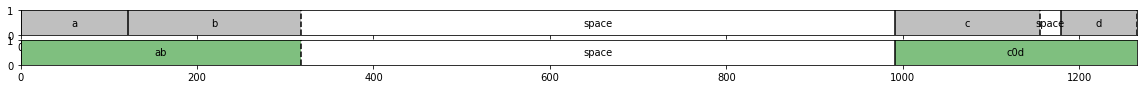

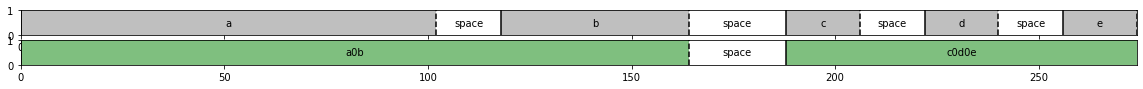

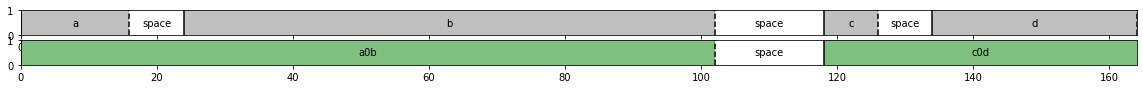

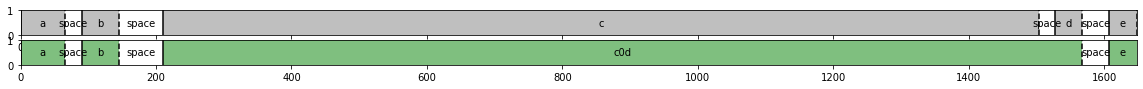

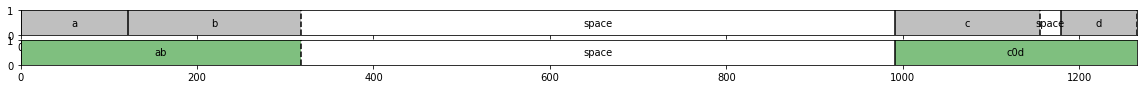

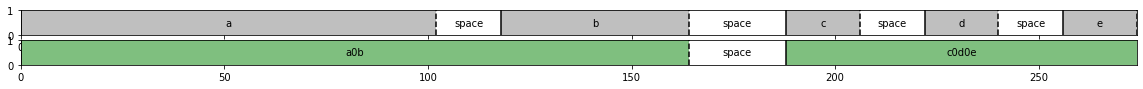

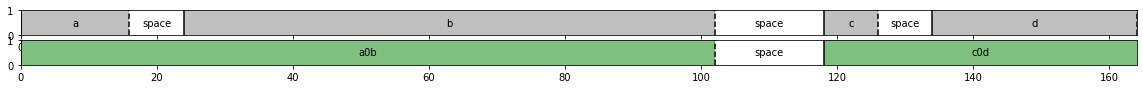

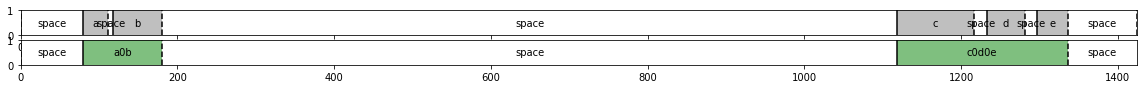

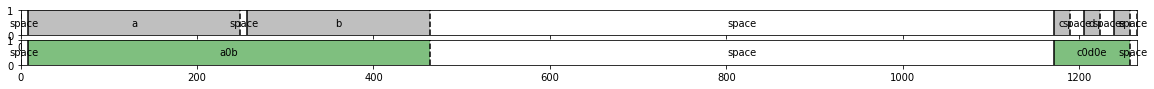

In [6]:
data = []
for file_name in os.listdir(DATA_FOLDER):
    file_path = os.path.join(DATA_FOLDER, file_name)
    with open(file_path, "r") as f:
        data.extend(json.load(f))
        
# let's visualize some of the data
for idx in range(10):
    print(data[idx])
    _ = visualize(data[idx]["input"], data[idx]["output"])
    print("-" * 100)

Analysis:
- we can see that some items that are in the same group can be separated by a small space between them/ or no space at all
- but finding the threshold for grouping is not easy, because there are some cases that the space between items are small, but they are not in the same group
- we can use a sliding window to find the threshold for grouping, i.e we can use size of current item and size of next space to determine whether we should group next item after the space or not

# Modelling

If we are only having 1D information: size of the item, we can use a simple model to predict whether we should group next item or not, but we can improve the model by adding more information:
- height of the item if it's horizontal order or width of the item if it's vertical order
- element type of the item: text, icon, etc.
- content of the element: text content, icon image, etc.
- current generated UI image

Below is the proposed model using all of the above information based on transformer encoder architecture:


In [8]:
Image.open(os.path.join("assets", "architecture.png"))

I'm happy to discuss more about the model if you are interested! 

The code is not implemented yet as we had discussed, but I'm happy to implement it if you are interested!

In [ ]:
###################################################### Thank you! ######################################################